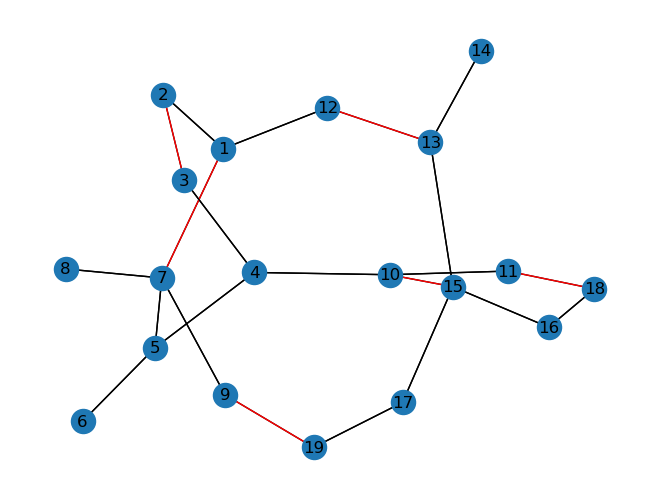

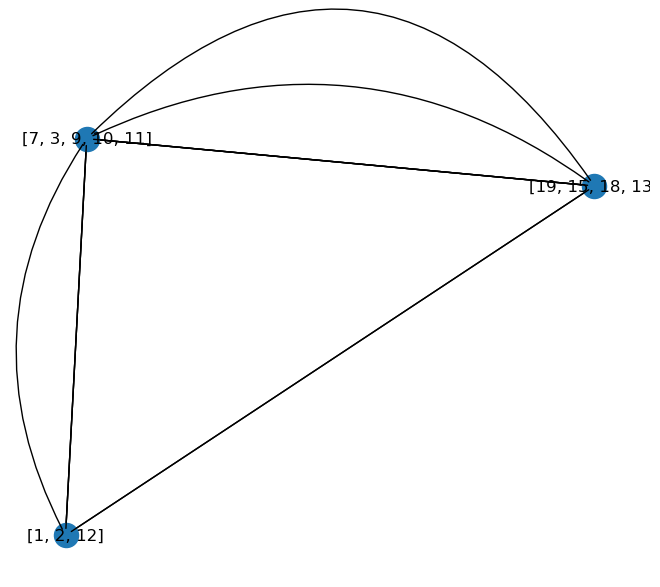

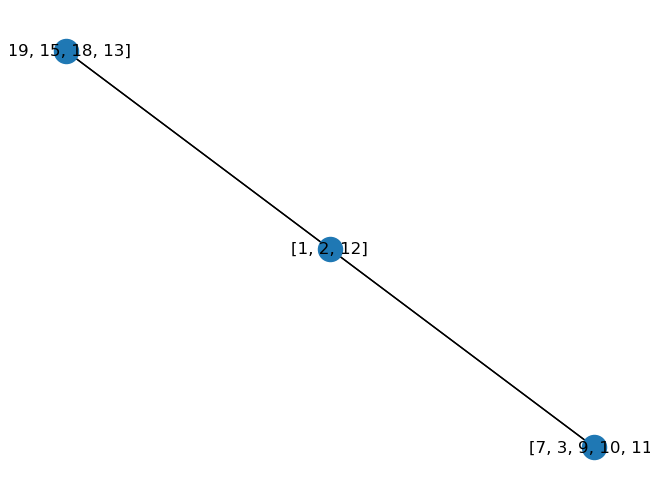

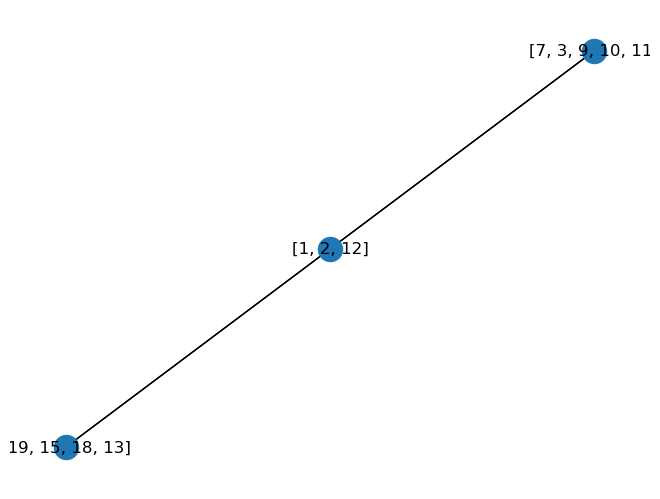

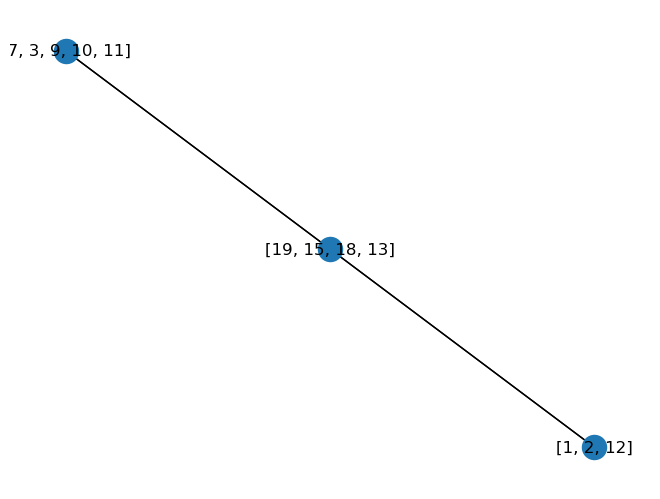

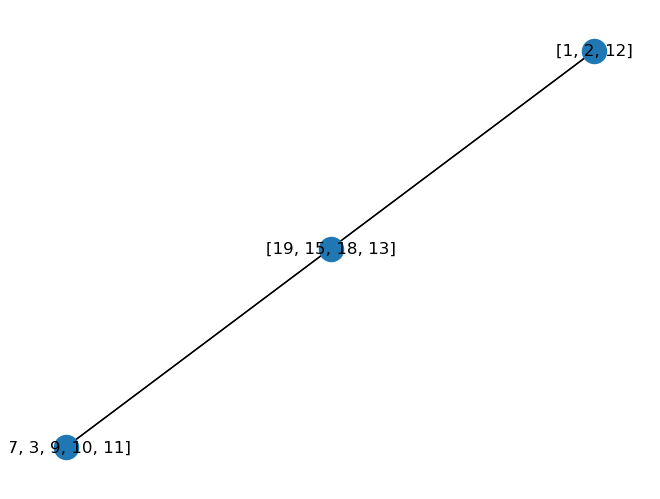

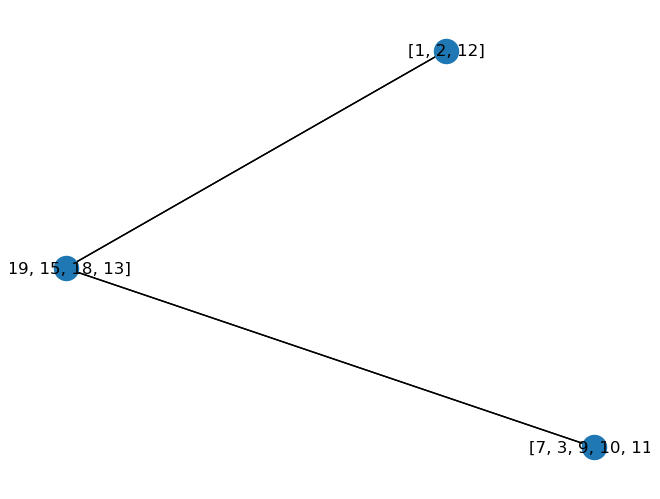

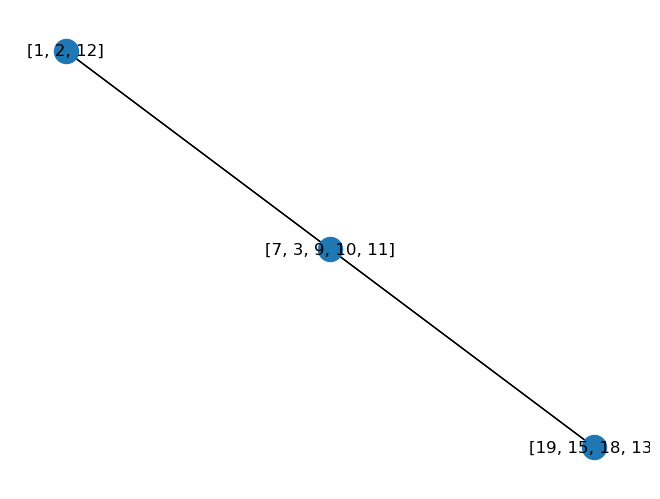

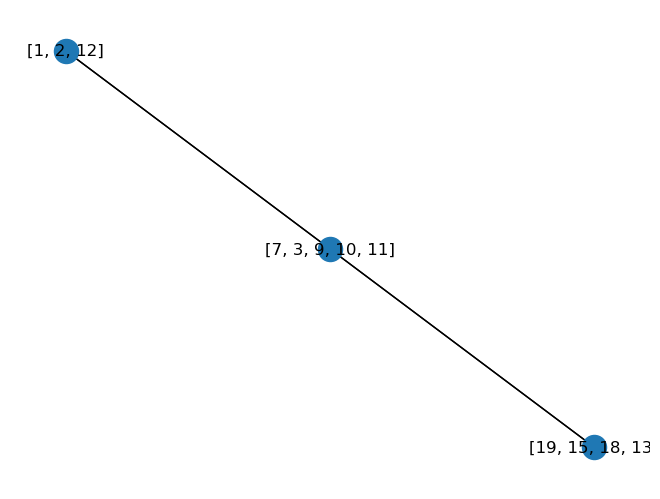

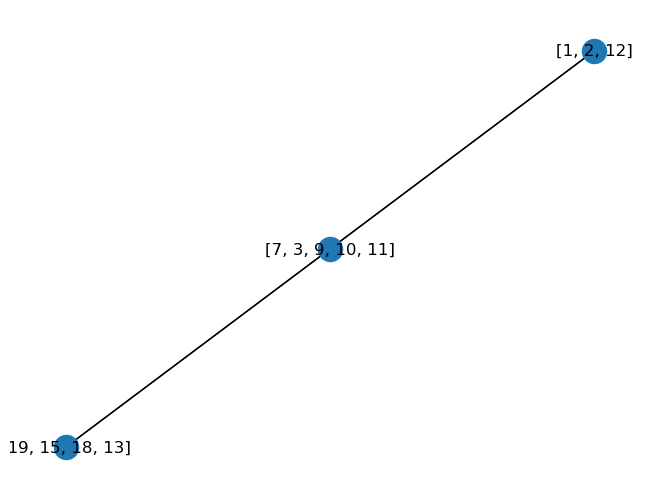

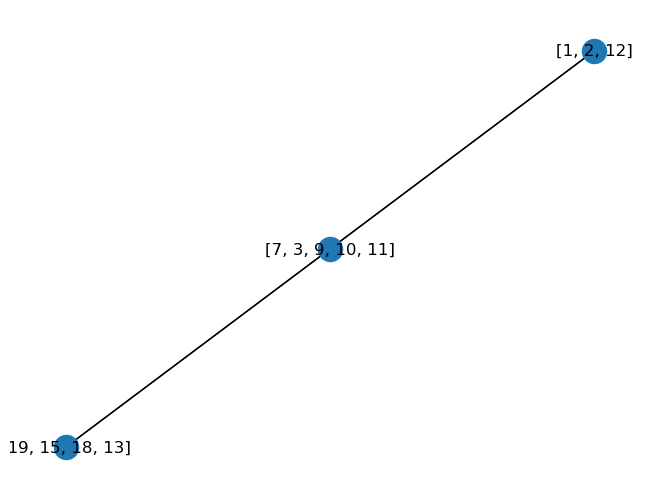

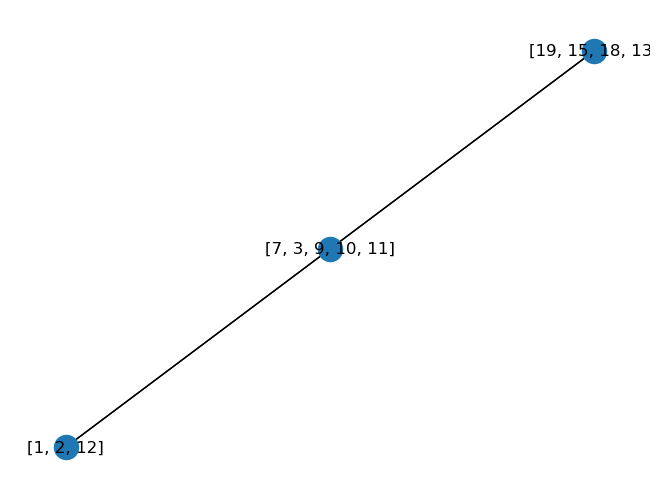

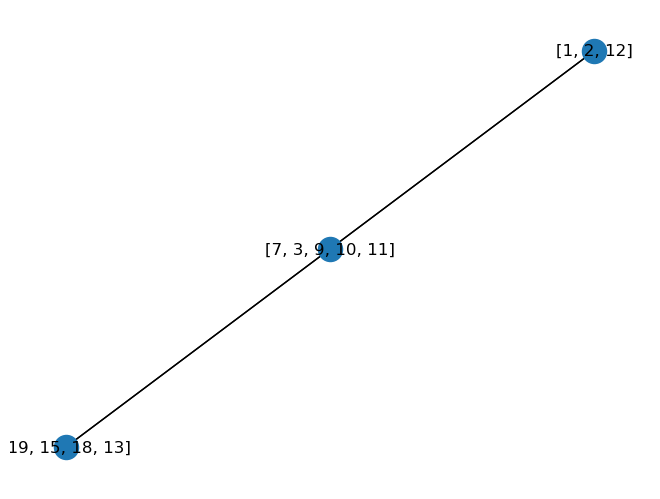

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy

G=nx.Graph()

#edge_list=list of edges where the weight 's' has been attributed to switches
edge_list=[(1,2,{'w':2}),(2,3,{'w':'s'}),(3,4,{'w':2}),(4,5,{'w':2}),(5,6,{'w':2}),
           (5,7,{'w':2}),(7,8,{'w':2}),(7,9,{'w':2}),(4,10,{'w':2}),(10,11,{'w':2}),
           (1,12,{'w':2}),(12,13,{'w':'s'}),(13,14,{'w':2}),(13,15,{'w':2}),
           (15,16,{'w':2}),(15,17,{'w':2}),(16,18,{'w':2}),(17,19,{'w':2}),
           (11,18,{'w':'s'}),(10,15,{'w':'s'}),(9,19,{'w':'s'}),(1,7,{'w':'s'})]

G.add_edges_from(edge_list)


#switches are colored in red and other edges in black
pos=nx.spring_layout(G)
colors=['k']*len(edge_list)
#switchL=list of switch edges
switchL=[]
i=0
for n1, n2, d in G.edges(data=True):
    if d['w']=='s':
        colors[i]='r'
        switchL.append((n1,n2))
    i=i+1
switchL2=list(sum(switchL,()))

nx.draw(G,pos,with_labels=True)
nx.draw_networkx_edges(G,edge_color=colors,pos=pos)
plt.axis("off")
plt.show()

#we create a new diconnected graph SG from G where we have removed all switches
Sedge_list=[]
SG=nx.Graph()
for n1, n2, d in G.edges(data=True):
    if d['w']!='s':
        Sedge_list.append((n1,n2))
SG.add_edges_from(Sedge_list)
Spos=nx.spring_layout(SG)
#we create a list with the connected components
cc=list(nx.connected_components(SG))
def convert(s):
    return list(map(lambda x: x, s))
ccl=[]
for x in range(len(cc)):
    ccl.append(convert(cc[x]))
#superN=list of super nodes. If they are in the same connected component they 
#constitute the same super node superN. 
#The label of each node is given by the list of the nodes of the original graph
#being the origin or the terminus of a switch edge.
superN=[]
for i in range(len(cc)):
    superN.append([])
    for a in switchL2:
        for b in ccl[i]:
            if a==b:
                superN[i].append(a)

#we create the super graph where the nodes are the super nodes and the edges are
#the switches of the original graph
superG=nx.MultiGraph()
for i in range(len(superN)):
    superG.add_node(str(superN[i]))

L=list(superG.nodes)
superEdge=[]
copySE=[]


for f in range(len(switchL)):
    superEdge.append([])
    j1=0
    for j4 in range(len(superN)):
        for j5 in range(len(superN[j4])):
            if switchL[f][j1]==superN[j4][j5]:
                superEdge[f].append(superN[j4])
                j1=1
for f in range(len(switchL)):
    copySE.append([])
    j1=0
    for j4 in range(len(superN)):
        for j5 in range(len(superN[j4])):
            if switchL[f][j1]==superN[j4][j5]:
                copySE[f].append(superN[j4])
                j1=1

#we create 2 separate lists of the multiple edges and of the single edges which
#will enable us to enumerate all the spanning trees afterwards 
multipleEdges=[]
singleEdges=[]
u=0
i2=1
multipleEdges.append([])
while len(copySE)>0 and i2<len(copySE):
    if copySE[0]==copySE[i2]:
        if len(multipleEdges[u])==0:
            multipleEdges.append([])
        multipleEdges[u].append(copySE[0])
        copySE.remove(copySE[i2])
    else:
        if i2<len(copySE)-1:
            i2=i2+1
        else:
            if len(multipleEdges[u])>0:
                multipleEdges[u].append(copySE[0])
                copySE.remove(copySE[0])
                u=u+1
                if len(copySE)>1:
                    i2=1
                else:
                    singleEdges.append(copySE[0])
            else:
                singleEdges.append(copySE[0])
multipleEdges.pop()

for iE in range(len(superEdge)):
    superG.add_edge(str(superEdge[iE][0]),str(superEdge[iE][1]))

superPos=nx.spring_layout(superG)
nx.draw(superG,superPos,with_labels=True)
ax = plt.gca()
for e in superG.edges:
    ax.annotate("",
                xy=superPos[e[0]], xycoords='data',
                xytext=superPos[e[1]], textcoords='data',
                arrowprops=dict(arrowstyle="-",shrinkA=5, shrinkB=5,patchA=None, patchB=None,connectionstyle="arc3,rad=rrr".replace('rrr',str(0.3*e[2])),))
plt.axis("off")
plt.show()
superGraphs=[]
g=len(multipleEdges[0])
for i in range(1,len(multipleEdges)):
   g=g*len(multipleEdges[i])

#superG is a multigraph so we need to redefine it as a graph without multiple
#edges to enumerate the spanning trees  with the SpanningTreeIterator
superG2=nx.Graph(superG)

#enumeration of all the spanning trees from the graph without multiple edges
sp_trees=[]
for z in nx.SpanningTreeIterator(superG2):
    sp_tree=nx.Graph()
    sp_trees.append(z.edges())

#we want to compare the edges from each spanning trees to the one in the list of
#the multipleEdges, when they match and there is n multiple edges then there will
#be n spanning trees being the same but with a different switch.
all_sp_trees=[]
for a in sp_trees:
    u=numpy.ones(len(a),dtype=int)
    for e in range(len(a)):
        for b in multipleEdges:
            if list(a)[e][0]==str(b[0][0]) and list(a)[e][1]==str(b[0][1]):
                u[e]=len(b)
    v=1
    for i in range(len(u)):
        v=v*u[i]
    for i in range(v):
        all_sp_trees.append(a)

#we plot all the spanning trees
for z in all_sp_trees:
    sp_tree=nx.Graph()
    sp_tree.add_edges_from(z)
    sp_tree_pos=nx.spring_layout(sp_tree)
    nx.draw(sp_tree,sp_tree_pos,with_labels=True)
    nx.draw_networkx_edges(sp_tree,pos=sp_tree_pos)
    plt.axis("off")
    plt.show()